# **50. データの入手・整形**

In [1]:
!wget https://archive.ics.uci.edu/ml/machine-learning-databases/00359/NewsAggregatorDataset.zip
!unzip NewsAggregatorDataset.zip

--2023-02-25 14:01:46--  https://archive.ics.uci.edu/ml/machine-learning-databases/00359/NewsAggregatorDataset.zip
Resolving archive.ics.uci.edu (archive.ics.uci.edu)... 128.195.10.252
Connecting to archive.ics.uci.edu (archive.ics.uci.edu)|128.195.10.252|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 29224203 (28M) [application/x-httpd-php]
Saving to: ‘NewsAggregatorDataset.zip’

NewsAggregatorDatas 100%[===================>]  27.87M  33.5MB/s    in 0.8s    

2023-02-25 14:01:47 (33.5 MB/s) - ‘NewsAggregatorDataset.zip’ saved [29224203/29224203]

Archive:  NewsAggregatorDataset.zip
  inflating: 2pageSessions.csv       
   creating: __MACOSX/
  inflating: __MACOSX/._2pageSessions.csv  
  inflating: newsCorpora.csv         
  inflating: __MACOSX/._newsCorpora.csv  
  inflating: readme.txt              
  inflating: __MACOSX/._readme.txt   


In [2]:
import pandas as pd
from sklearn.model_selection import train_test_split

# データの読み込み
df = pd.read_csv("newsCorpora.csv", sep="\t", names=("ID","TITLE","URL","PUBLISHER","CATEGORY","STORY","HOSTNAME","TIMESTAMP"))

# "TITLE"と"CATEGORY"を抽出
data = df.loc[df["PUBLISHER"].isin(["Reuters","Huffington Post","Businessweek","Contactmusic.com","Daily Mail"]), ["TITLE","CATEGORY"]]

# データ分割　学習:検証:テスト=8:1:1
train, others = train_test_split(data, test_size=0.2, random_state=0, shuffle=True)
dev, test = train_test_split(others, test_size=0.5, random_state=0, shuffle=True)

# ファイルに保存
train.to_csv("train.txt", sep="\t", index=None)
dev.to_csv("dev.txt", sep="\t", index=None)
test.to_csv("test.txt", sep="\t", index=None)

# 事例数の確認
print(f'学習データの事例数\n{train["CATEGORY"].value_counts()}\n')
print(f'検証データの事例数\n{dev["CATEGORY"].value_counts()}\n')
print(f'テストデータの事例数\n{test["CATEGORY"].value_counts()}\n')

学習データの事例数
b    4481
e    4240
t    1214
m     737
Name: CATEGORY, dtype: int64

検証データの事例数
b    575
e    528
t    137
m     94
Name: CATEGORY, dtype: int64

テストデータの事例数
b    571
e    511
t    173
m     79
Name: CATEGORY, dtype: int64



# **51. 特徴量抽出**


In [3]:
import string
import re

def preprocessing(text):
  table = str.maketrans(string.punctuation, ' '*len(string.punctuation))
  text = text.translate(table)  # 記号をスペースに置換
  text = text.lower()  # 小文字化
  text = re.sub('[0-9]+', '', text)  # 数字除去
  return text

In [4]:
from sklearn.feature_extraction.text import TfidfVectorizer

# 前処理
train["TITLE"] = train["TITLE"].map(lambda x: preprocessing(x))
dev["TITLE"] = dev["TITLE"].map(lambda x: preprocessing(x))
test["TITLE"] = test["TITLE"].map(lambda x: preprocessing(x))

# TfidfVectorizerでベクトル化
vectorizer = TfidfVectorizer(max_features=3000)
X_train = vectorizer.fit_transform(train["TITLE"])
X_dev = vectorizer.transform(dev["TITLE"])
X_test = vectorizer.transform(test["TITLE"])

# データ変換
X_train = pd.DataFrame(X_train.toarray(), columns=vectorizer.get_feature_names())
X_dev = pd.DataFrame(X_dev.toarray(), columns=vectorizer.get_feature_names())
X_test = pd.DataFrame(X_test.toarray(), columns=vectorizer.get_feature_names())

# ファイルに保存
X_train.to_csv("train.feature.txt", sep="\t", index=False)
X_dev.to_csv("dev.feature.txt", sep="\t", index=False)
X_test.to_csv("test.feature.txt", sep="\t", index=False)

/usr/local/lib/python3.8/dist-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function get_feature_names is deprecated; get_feature_names is deprecated in 1.0 and will be removed in 1.2. Please use get_feature_names_out instead.
  warnings.warn(msg, category=FutureWarning)


# **52. 学習**

In [10]:
from sklearn.linear_model import LogisticRegression

model = LogisticRegression(random_state=0, max_iter=1000)
model.fit(X_train, train["CATEGORY"])

LogisticRegression(max_iter=1000, random_state=0)

# **53. 予測**

In [11]:
import numpy as np

def prediction(model, X):
    return [np.max(model.predict_proba(X), axis=1), model.predict(X)]

train_pred = prediction(model, X_train)
test_pred = prediction(model, X_test)

# **54. 正解率の計測**

In [12]:
from sklearn.metrics import accuracy_score

print(f'正解率（検証データ）：{accuracy_score(train_pred[1], train["CATEGORY"])}')
print(f'正解率（テストデータ）：{accuracy_score(test_pred[1], test["CATEGORY"])}')

正解率（検証データ）：0.9320652173913043
正解率（テストデータ）：0.8755622188905547


# **55. 混同行列の作成**

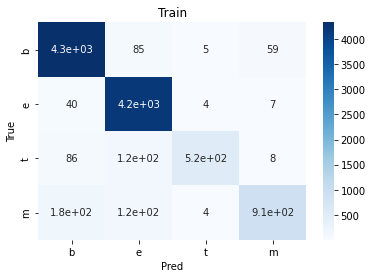

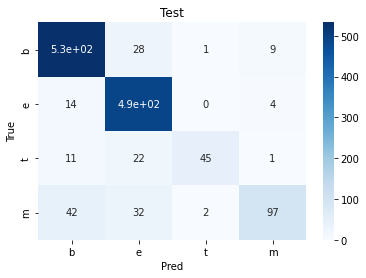

In [13]:
from sklearn.metrics import confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt

labels = ["b","e","t","m"]
train_cm = confusion_matrix(train["CATEGORY"], train_pred[1])
ax1 = sns.heatmap(train_cm, annot=True, cmap='Blues', xticklabels=labels, yticklabels=labels)
ax1.set_title("Train")
ax1.set_xlabel("Pred")
ax1.set_ylabel("True")
plt.show()

test_cm = confusion_matrix(test["CATEGORY"], test_pred[1])
ax2 = sns.heatmap(test_cm, annot=True, cmap='Blues', xticklabels=labels, yticklabels=labels)
ax2.set_title("Test")
ax2.set_xlabel("Pred")
ax2.set_ylabel("True")
plt.show()

# **56. 適合率，再現率，F1スコアの計測**

In [14]:
from IPython.display import display
from sklearn.metrics import precision_score
from sklearn.metrics import recall_score
from sklearn.metrics import f1_score

labels = ["b","e","t","m"]
precision = precision_score(test["CATEGORY"], test_pred[1], average=None, labels=labels)
precision_micro = precision_score(test["CATEGORY"], test_pred[1], average="micro")
precision_macro = precision_score(test["CATEGORY"], test_pred[1], average="macro")
precision = np.append(precision, [precision_micro, precision_macro])

recall = recall_score(test["CATEGORY"], test_pred[1], average=None, labels=labels)
recall_micro = recall_score(test["CATEGORY"], test_pred[1], average="micro")
recall_macro = recall_score(test["CATEGORY"], test_pred[1], average="macro")
recall = np.append(recall, [recall_micro, recall_macro])

f1 = f1_score(test["CATEGORY"], test_pred[1], average=None, labels=labels)
f1_micro = f1_score(test["CATEGORY"], test_pred[1], average="micro")
f1_macro = f1_score(test["CATEGORY"], test_pred[1], average="macro")
f1 = np.append(f1, [f1_micro, f1_macro])

result = pd.DataFrame({"x":precision, "y":recall, "z":f1},
                      index=["b","e","t","m","マイクロ平均","マクロ平均"])

display(result)

,x,y,z
b,0.888333,0.933450,0.910333
e,0.857391,0.964775,0.907919
t,0.873874,0.560694,0.683099
m,0.937500,0.569620,0.708661
マイクロ平均,0.875562,0.875562,0.875562
マクロ平均,0.889275,0.757135,0.802503


# **57. 特徴量の重みの確認**

* classes_：クラスのリスト
* coef_：クラスごとの各特徴量の重み

In [28]:
features = X_train.columns.tolist()
for c, coef in zip(model.classes_, model.coef_):
    features_values = []
    for feature, value in zip(features, coef):
        features_values.append([feature, value])
    sorted_features_values = sorted(features_values, key=lambda x:x[1])
    best10 = sorted_features_values[::-1][:10]
    worst10 = sorted_features_values[:10]
    print(f'クラス：{c}')
    print(f'  トップ10：{best10}')
    print(f'ワースト10：{worst10}\n')

クラス：b
  トップ10：[['bank', 3.3481437770604234], ['fed', 3.286937393706155], ['china', 3.2269269839852455], ['stocks', 3.1216289857211414], ['ecb', 3.107436446595023], ['euro', 2.777518433229443], ['ukraine', 2.498549785847966], ['dollar', 2.4260299585620384], ['profit', 2.3827051175403793], ['oil', 2.378680585096066]]
ワースト10：[['ebola', -1.964941984768087], ['video', -1.822428820452273], ['her', -1.8224007244344014], ['and', -1.8221787372406315], ['she', -1.743441090031147], ['star', -1.6955395462454423], ['study', -1.6296234150382505], ['drug', -1.5830881709557385], ['virus', -1.5827307233441765], ['microsoft', -1.5698249913841467]]

クラス：e
  トップ10：[['kardashian', 3.10662202824927], ['chris', 2.710382708011364], ['kim', 2.4091888944715665], ['miley', 2.37395778857189], ['star', 2.3369210627188712], ['movie', 2.3190027066790013], ['cyrus', 2.3157438937286345], ['film', 2.246781323102267], ['paul', 2.1948633070650017], ['she', 2.186950969345273]]
ワースト10：[['update', -3.2126083322547605], ['us

# **58. 正則化パラメータの変更**

In [43]:

results = []
for c in [0.0001, 0.001, 0.01, 0.1, 1, 10, 100]:
    # 学習
    model = LogisticRegression(C=c, random_state=0, max_iter=1000)
    model.fit(X_train, train["CATEGORY"])

    # 予測
    train_pred = model.predict(X_train)
    dev_pred = model.predict(X_dev)
    test_pred = model.predict(X_test)

    # 正解率の算出
    train_acc = accuracy_score(train_pred, train["CATEGORY"])
    dev_acc = accuracy_score(dev_pred, dev["CATEGORY"])
    test_acc = accuracy_score(test_pred, test["CATEGORY"])

    results.append([c, train_acc, dev_acc, test_acc])

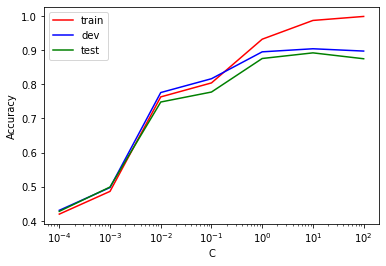

In [44]:
results = np.array(results).T
plt.plot(results[0], results[1], label="train", color="red")
plt.plot(results[0], results[2], label="dev", color="blue")
plt.plot(results[0], results[3], label="test", color="green")
plt.xlabel("C")
plt.ylabel("Accuracy")
plt.xscale("log")
plt.legend()
plt.show()

# **59. ハイパーパラメータの探索**

In [49]:
import itertools

best_acc = 0
best_c = 1
best_solver = "saga"
C = [0.01, 0.1, 1, 5, 10]
solvers = ["saga", "newton-cg", "lbfgs", "liblinear"]
params = itertools.product(C, solvers)
for c, solver in params:
    model = LogisticRegression(C=c, solver=solver, random_state=0, max_iter=1000)
    model.fit(X_train, train["CATEGORY"])
    y_pred = model.predict(X_dev)
    acc = accuracy_score(y_pred, dev["CATEGORY"])
    if acc > best_acc:
        best_acc = acc
        best_c = c
        best_solver = solver
    print("正解率 = %.3f  C = %s　solver = %s" % (acc, str(c), solver))
print("最適なハイパーパラメタは C = %s solver = %s" % (str(best_c), best_solver))

正解率 = 0.776  C = 0.01　solver = saga
正解率 = 0.776  C = 0.01　solver = newton-cg
正解率 = 0.776  C = 0.01　solver = lbfgs
正解率 = 0.766  C = 0.01　solver = liblinear
正解率 = 0.816  C = 0.1　solver = saga
正解率 = 0.816  C = 0.1　solver = newton-cg
正解率 = 0.816  C = 0.1　solver = lbfgs
正解率 = 0.801  C = 0.1　solver = liblinear
正解率 = 0.895  C = 1　solver = saga
正解率 = 0.895  C = 1　solver = newton-cg
正解率 = 0.895  C = 1　solver = lbfgs
正解率 = 0.891  C = 1　solver = liblinear
正解率 = 0.906  C = 5　solver = saga
正解率 = 0.906  C = 5　solver = newton-cg
正解率 = 0.906  C = 5　solver = lbfgs
正解率 = 0.911  C = 5　solver = liblinear
正解率 = 0.904  C = 10　solver = saga
正解率 = 0.904  C = 10　solver = newton-cg
正解率 = 0.904  C = 10　solver = lbfgs
正解率 = 0.909  C = 10　solver = liblinear
最適なハイパーパラメタは C = 5 solver = liblinear


In [50]:
model = LogisticRegression(C=best_c, solver=best_solver, random_state=0, max_iter=1000)
model.fit(X_train, train["CATEGORY"])
y_pred = model.predict(X_test)
acc = accuracy_score(y_pred, test["CATEGORY"])
print(f'test:{acc}')

test:0.8935532233883059


デフォルトより0.02上がった。